# Laplacian Associative Memory (LAM) - RL | BOTTLENECK

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import networkx
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

In [2]:
class LAM():
    def __init__(self, N, P, prob, H, gamma, norm_mode):
        self.N = N
        self.P = P
        self.prob = prob
        self.H = H
        self.gamma = gamma
        self.norm_mode = norm_mode

        self.V = self.prob * (1-self.prob)
        self.NV = self.N * self.V
        
        # GENERATE PATTERNS
        self.xi = (np.random.rand(self.N, self.P) < self.prob).astype('float') # Binary dipole (+/-) input with sparsity
        self.xi_mean = np.sum(self.xi, axis=1, keepdims=True) / self.P
        self.xi_bias = self.xi - self.xi_mean

        # NORMALIZATION
        if self.norm_mode == "sym": # SYMMETRIC WEIGHTS
            Dnorm = np.diag(np.sum(self.H, axis=1)**-0.5)
            self.H = Dnorm @ self.H @ Dnorm
            self.Wauto = (self.xi_bias @ self.xi_bias.T) / self.NV
            self.Whetero = (self.xi_bias @ self.H @ self.xi_bias.T) / self.NV
            self.WG = self.gamma / self.N

        elif self.norm_mode == "asym": # ASYMMETRIC WEIGHTS
            Dnorm = np.diag(np.sum(self.H, axis=1)**-1) # Degree matrix
            self.H = Dnorm @ self.H # Hetero-associative weights
            self.Wauto = (self.xi @ self.xi.T) / self.NV # Local inhibition
            self.Whetero = (self.xi @ self.H @ self.xi.T) / self.NV # Excitatory
            self.WG = self.P * self.xi_mean @ self.xi_mean.T / self.NV + self.gamma / self.N # Global inhibition
        else:
            print("Error: Normalization mode 'sym' or 'asym' was not specified.")
            exit()

    def _step(self, z): # Heaviside step function
        return 0.5 * np.sign(z) + 0.5

    def _set_weight(self, a): # Decompose weights
        self.W = a * self.Wauto + self.Whetero - (a+1) * self.WG

    def simulate_single_changeparam(self, a_array, eta, epochs, start_node):
        if len(a_array)!=epochs:
            print("Error: Length of a_array must be matched to epochs.")
            exit()

        self.x = self.xi[:,start_node] + 0.0
        self.m_log = np.zeros([epochs,self.P])
        for t in tqdm(range(epochs)):
            a = a_array[t]
            self._set_weight(a)
            self.r = self._step(self.W @ self.x)
            self.x += eta * (self.r - self.x)
            self.m = (self.xi_bias.T @ self.x) / (self.N * self.V)
            self.m_log[t,:] = self.m

        return self.m_log

---

### BUILD NETWORK (RING)

In [3]:
N = 90
bias = 1

group_id = []
pos = {}
edge_list = []
edge_list_now = []

# Track
for x in range(0, N):
    angle = 2 * np.pi * x / N
    pos[x] = [np.cos(angle), np.sin(angle)]
    group_id.append(x)
    if x > 0:
        edge_list.append((x-1, x, 10+bias))
        edge_list.append((x, x-1, 10-bias))
        edge_list_now.append((x, x-1))

# Loop
edge_list.append((N-1, 0, 10+bias))
edge_list.append((0, N-1, 10-bias))
edge_list_now.append((0, N-1))

# Adjacency matrix
W=np.zeros([N,N])
for x in edge_list:
    W[x[0],x[1]] = x[2]

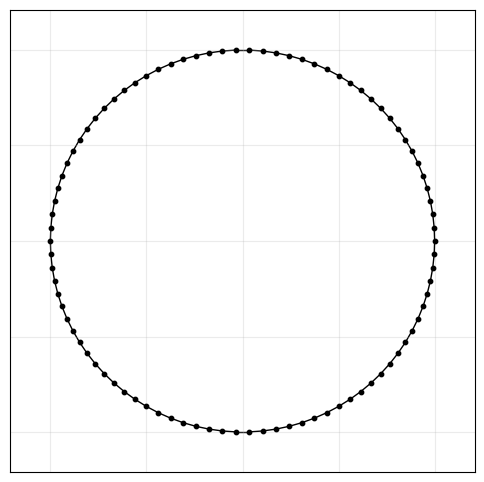

In [4]:
plt.figure(figsize=(6,6))
plt.grid('on', alpha=0.25)
G = networkx.Graph()
G.add_edges_from(edge_list_now)
networkx.draw_networkx_nodes(G, pos, node_color="black", node_size=10)
networkx.draw_networkx_edges(G, pos)

---

### COMPUTE GRAPH

In [5]:
P = W.shape[0]
N = 1024
prob = 0.1
eta = 0.1
epochs = 10000
gamma = 0.6

period = 500.0
a_arr = 0.9 * np.cos(2 * np.pi * np.arange(epochs) / period)

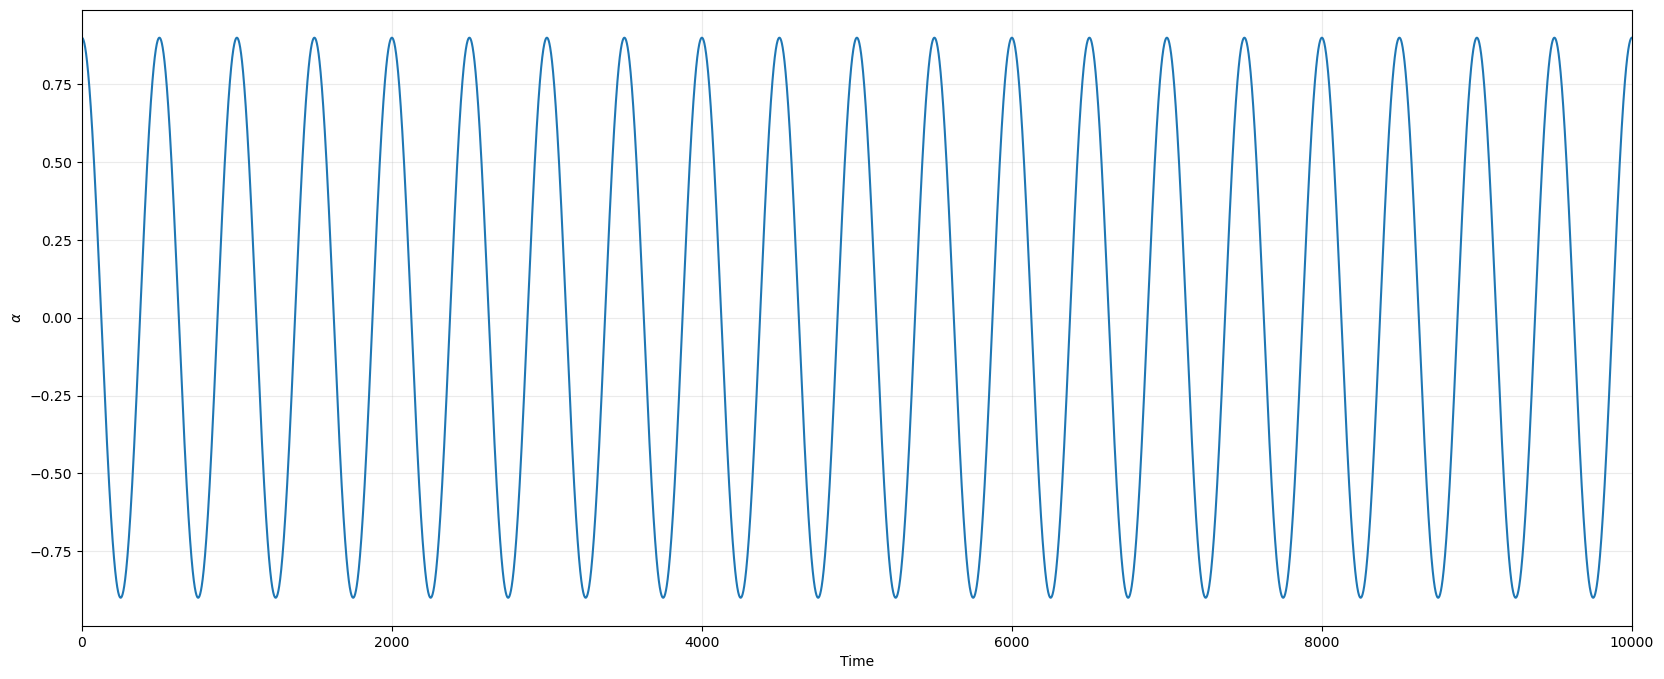

In [6]:
plt.figure(figsize=(20,8))
plt.plot(a_arr)
plt.xlabel("Time"), plt.ylabel(r"$\alpha$")
plt.xlim([0,epochs])
plt.grid('on', alpha=0.25)

In [7]:
graph = LAM(N, P, prob, W, gamma, norm_mode="asym")
m_log = graph.simulate_single_changeparam(a_arr, eta, epochs, start_node=0)

100%|██████████| 10000/10000 [00:19<00:00, 510.14it/s]


---

### PLOT RESULTS

(Text(0.5, 0, 'Time'), Text(0, 0.5, 'Pattern'))

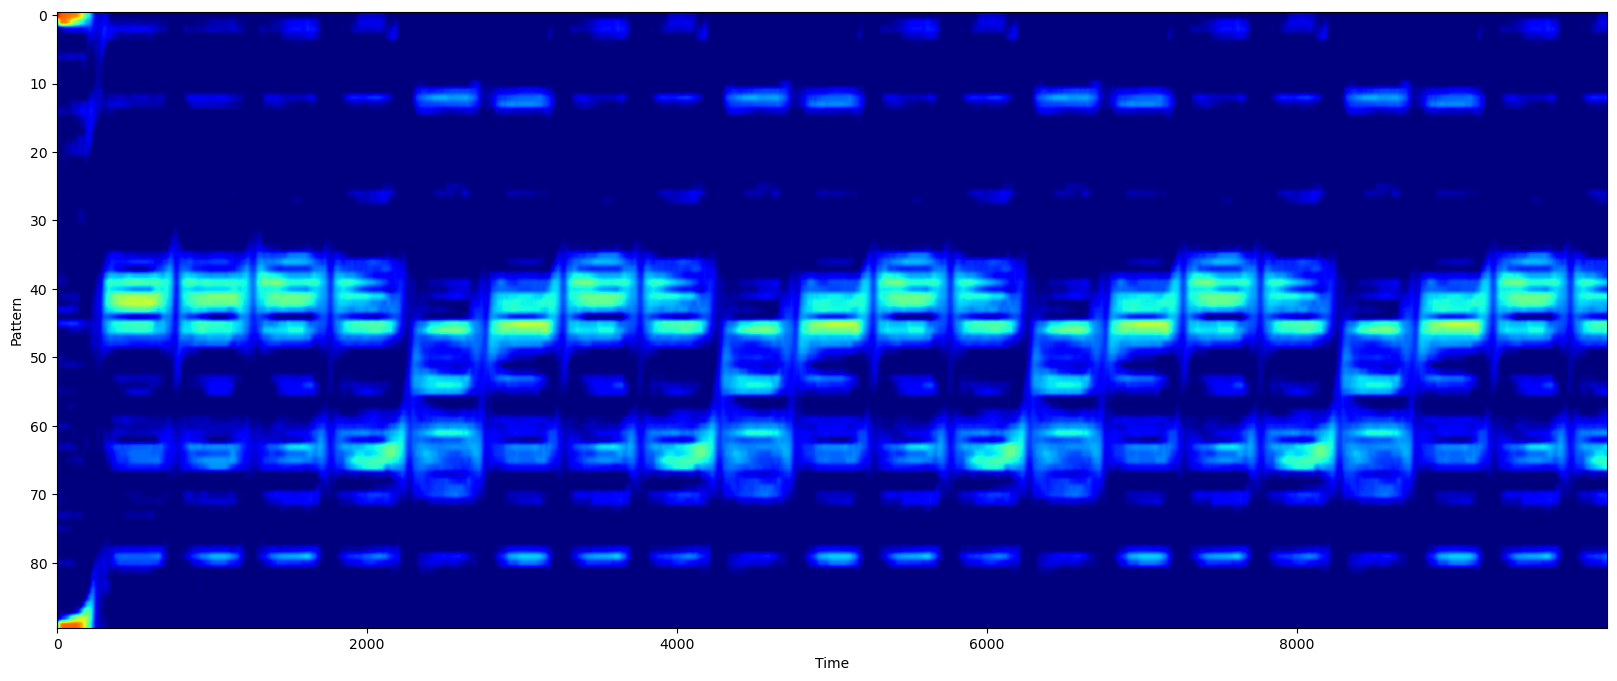

In [8]:
m_time = m_log

Lgap = 1
peak = np.argmax(m_time, axis=1)
vel = (peak - np.roll(peak, Lgap))
vel[vel<-1] = vel[vel<-1] + P
vel = vel/Lgap
vel[:Lgap] = 0.0

Nactive = np.sum(m_time>0.01, axis=1)
m_time[m_time<0] = 0.0

plt.figure(figsize=(20,8))
plt.imshow(m_time.T, aspect="auto", cmap="jet")
plt.xlabel("Time"), plt.ylabel("Pattern")

(None, None)

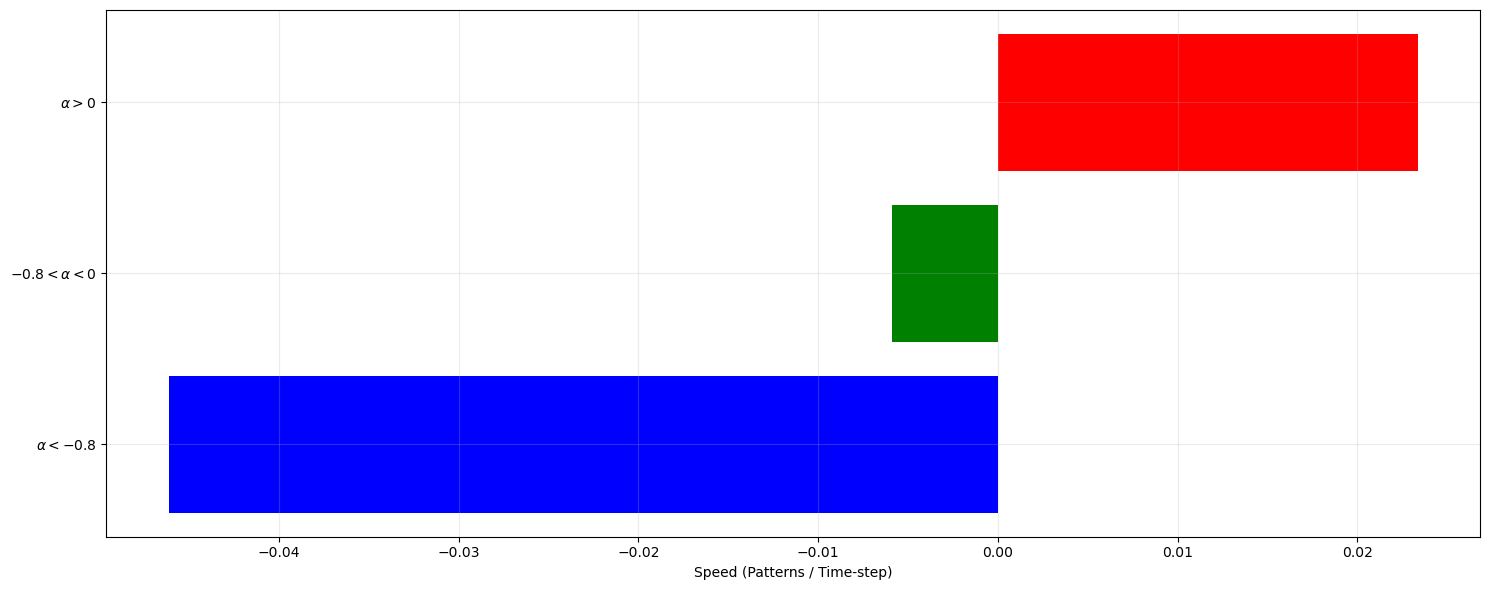

In [9]:
Phalf = int(P//2)

Lgap = 5
peak = np.argmax(m_time, axis=1)
vel = (peak - np.roll(peak, Lgap))
vel[vel<-Phalf] = vel[vel<-Phalf] + P
vel[vel>Phalf] = vel[vel>Phalf] - P
vel=vel / Lgap
vel[:Lgap] = 0.0

vel_hi = np.mean(vel[a_arr>0.0])
vel_mid = np.mean(vel[(a_arr<0.0) * (a_arr>-0.8)])
vel_lo = np.mean(vel[(a_arr<-0.8)])

plt.figure(figsize=(15,6))
plt.barh([2,1,0], [vel_hi, vel_mid, vel_lo], tick_label=[r"$\alpha>0$", r"$-0.8<\alpha<0$", r"$\alpha<-0.8$"], color=["red","green","blue"])
plt.xlabel("Speed (Patterns / Time-step)")
plt.tight_layout(), plt.grid('on', alpha=0.25)

(<matplotlib.legend.Legend at 0x7f8b11082f70>, None)

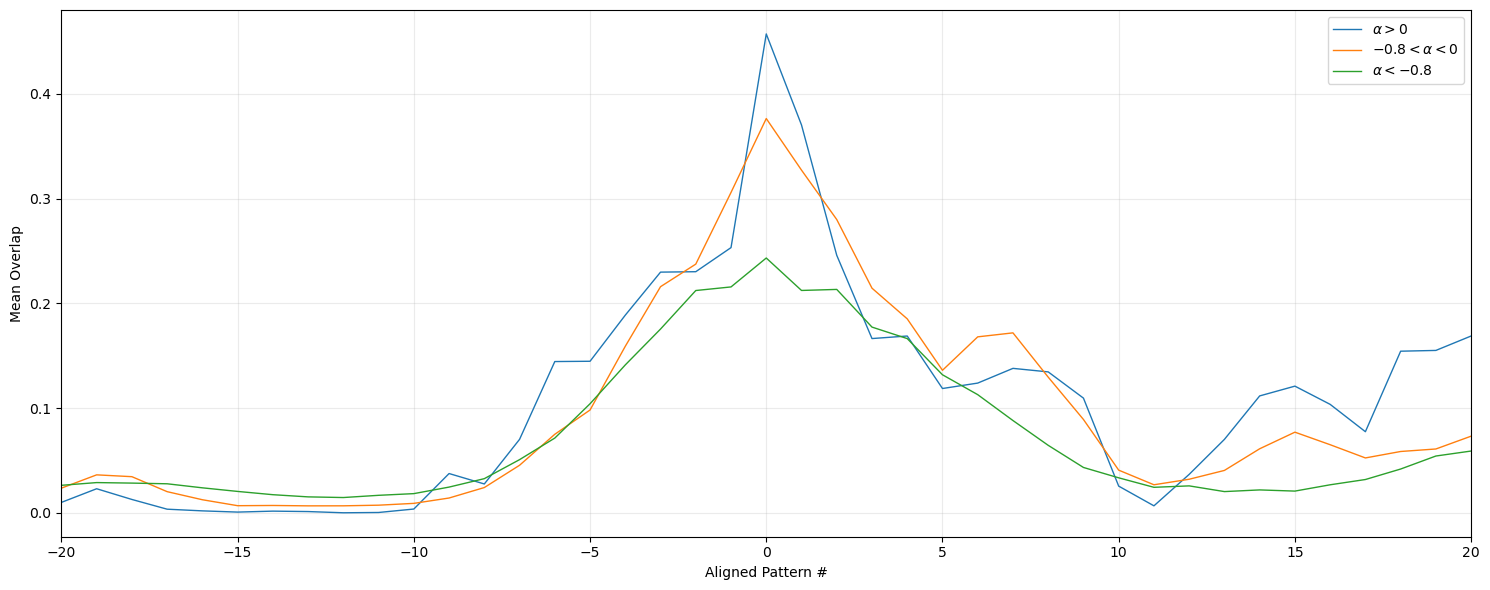

In [10]:
for t in range(len(m_time)):
    m_time[t,:] = np.roll(m_time[t,:], Phalf-np.argmax(m_time[t,:]))

mean_hi = np.mean(m_time[a_arr>0,:], axis=0)
mean_mid = np.mean(m_time[(a_arr<0.0)*(a_arr>-0.8),:], axis=0)
mean_lo = np.mean(m_time[(a_arr<-0.8),:], axis=0)

x = np.arange(P) - Phalf
plot_width = 20
ind = range(Phalf-plot_width, Phalf+plot_width+1)

plt.figure(figsize=(15,6))
plt.plot(x[ind],mean_hi[ind], label=r"$\alpha>0$", lw=1)
plt.plot(x[ind],mean_mid[ind], label=r"$-0.8<\alpha<0$", lw=1)
plt.plot(x[ind],mean_lo[ind], label=r"$\alpha<-0.8$", lw=1)
plt.xlabel("Aligned Pattern #"), plt.ylabel("Mean Overlap")
plt.xlim([-20,20]), plt.grid('on', alpha=0.25)
plt.legend(), plt.tight_layout()

In [11]:
# # Overlap
# datalen=m_log.shape[0]
# m_max=np.max(m_log)
# m_min=np.min(m_log)

# plot_pitch=10

# # Plot
# count=0
# for t in range(datalen):
#     if t%plot_pitch==0:
#         m=m_log[t,:]
#         plt.figure(figsize=(12,6))
#         x=range(1,len(m)+1)
#         plt.plot(x,m)
#         plt.plot(x,[0]*len(m),color="black")
#         plt.title("t="+str(t), fontsize=20)      
#         plt.xlabel("Patterns"), plt.ylabel("Overlap")
#         plt.xlim([1,len(m)]), plt.ylim([m_min,m_max])
#         plt.tight_layout()
#         plt.savefig("img"+str(count).zfill(4)+".png")
#         count=count+1

# # Render
# import os 
# os.system("ffmpeg -r 20 -i img%04d.png -vsync cfr movie.gif")
# os.system("rm img*.png")